In [434]:
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('Brain.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])

In [435]:
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)

(362, 434, 10)
(362, 434, 10)


In [436]:
# Max and min label
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

5
0


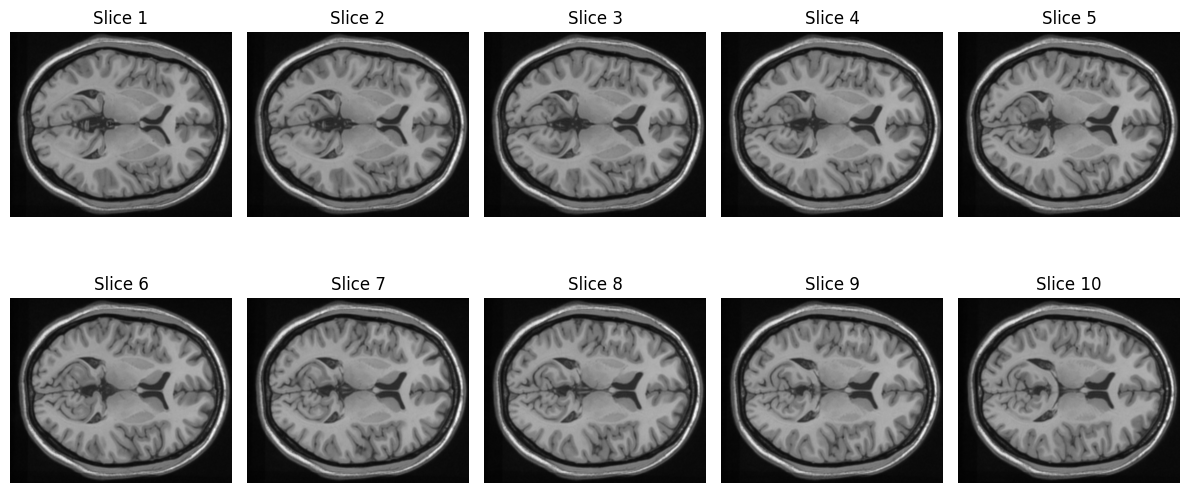

In [437]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_stacked[:, :, i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

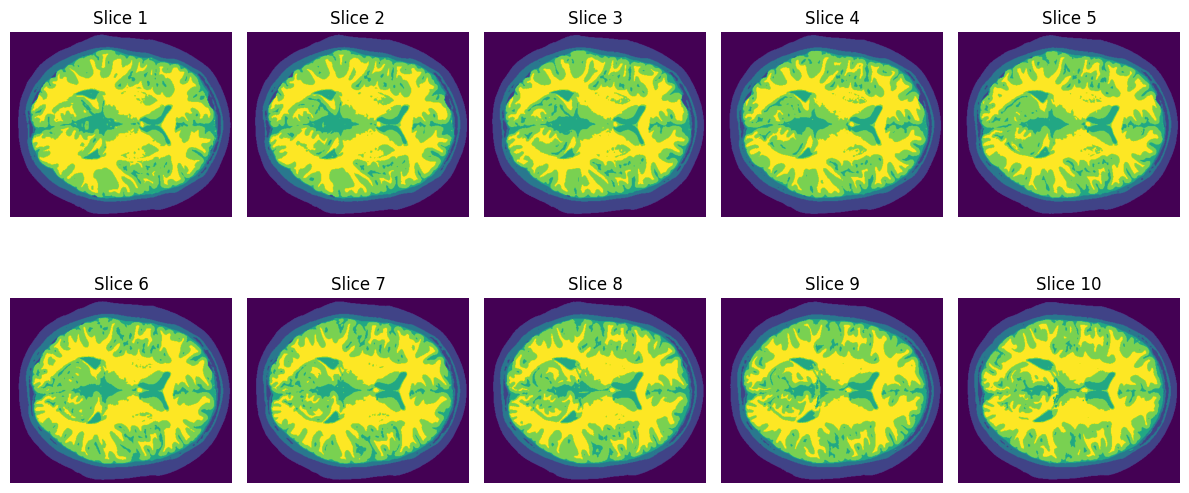

In [438]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_labels[:, :, i])
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

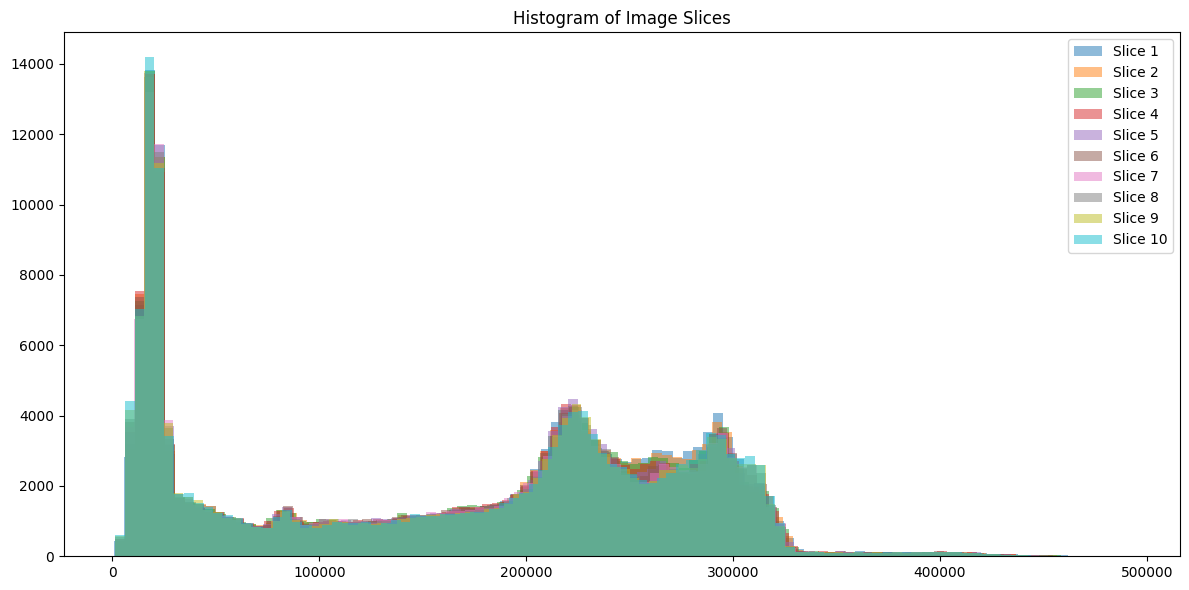

In [439]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(mri_stacked.shape[2]):
    hist = plt.hist(mri_stacked[:, :, i].flatten(), bins=100, alpha=0.5, label=f'Slice {i+1}')

ax.set_title('Histogram of Image Slices')
ax.legend()

plt.tight_layout()
plt.show()


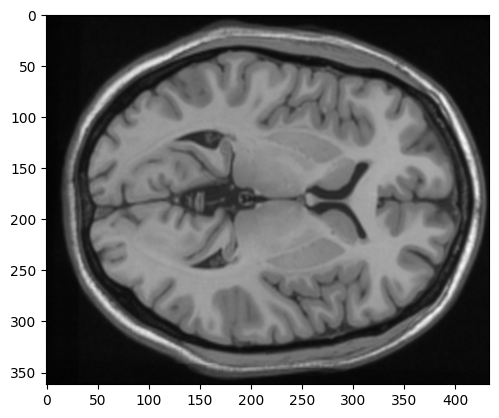

In [440]:
reference_img = mri_stacked[:,:,0]
plt.imshow(reference_img, cmap='gray')

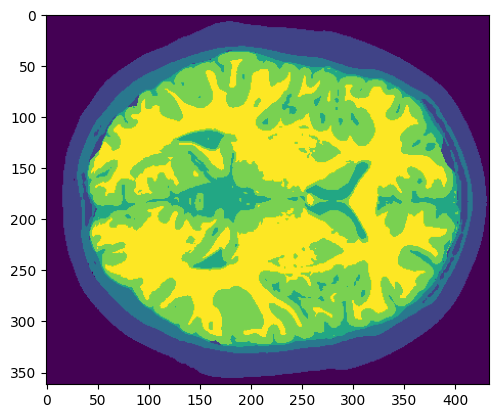

In [441]:
reference_labels = mri_labels[:,:,0]
plt.imshow(reference_labels)

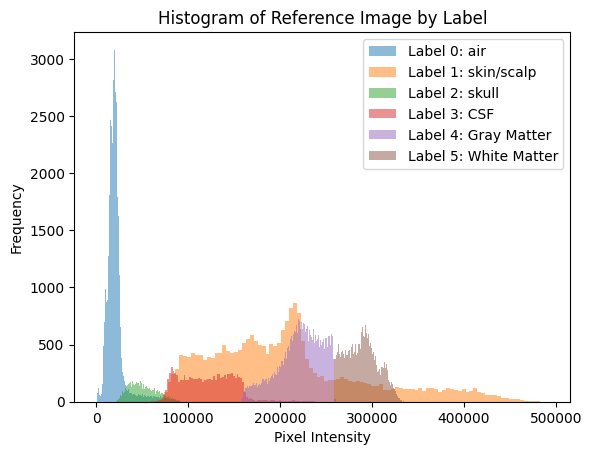

In [442]:
import utils

utils.plot_frequencies(reference_img, reference_labels)

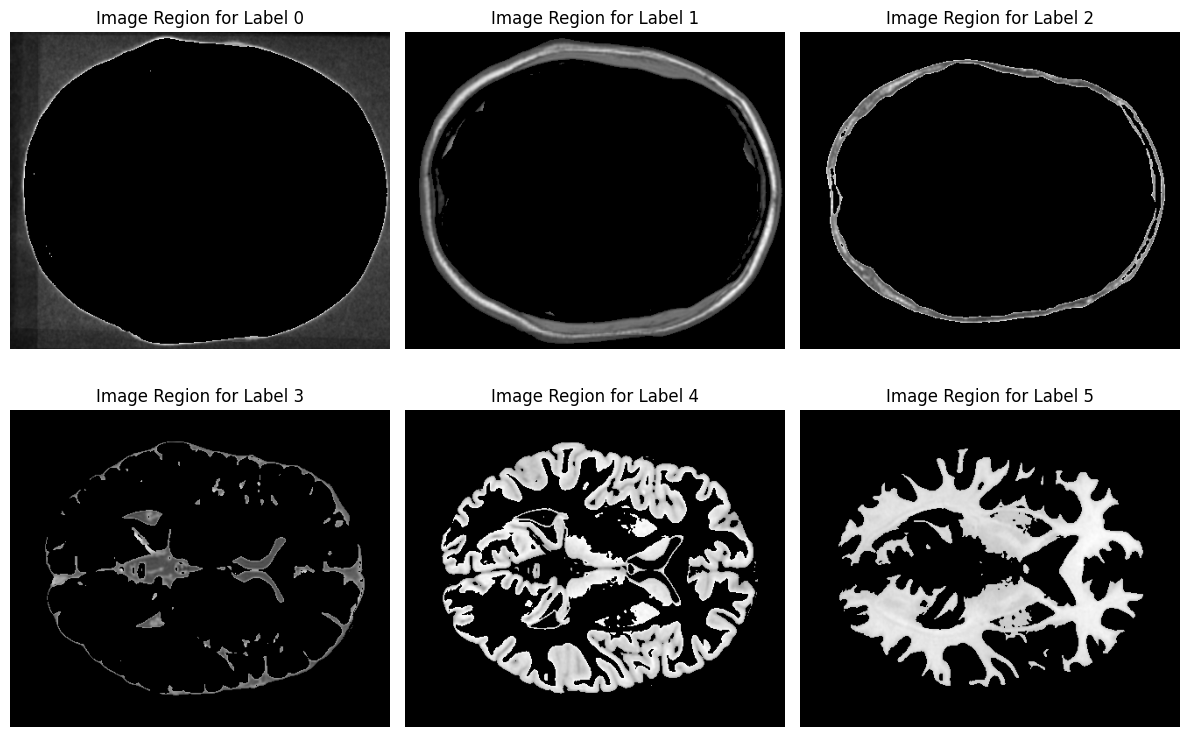

In [443]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = reference_img * (reference_labels == i)
    ax.imshow(mask.reshape(reference_img.shape), cmap='gray')
    ax.set_title(f'Image Region for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


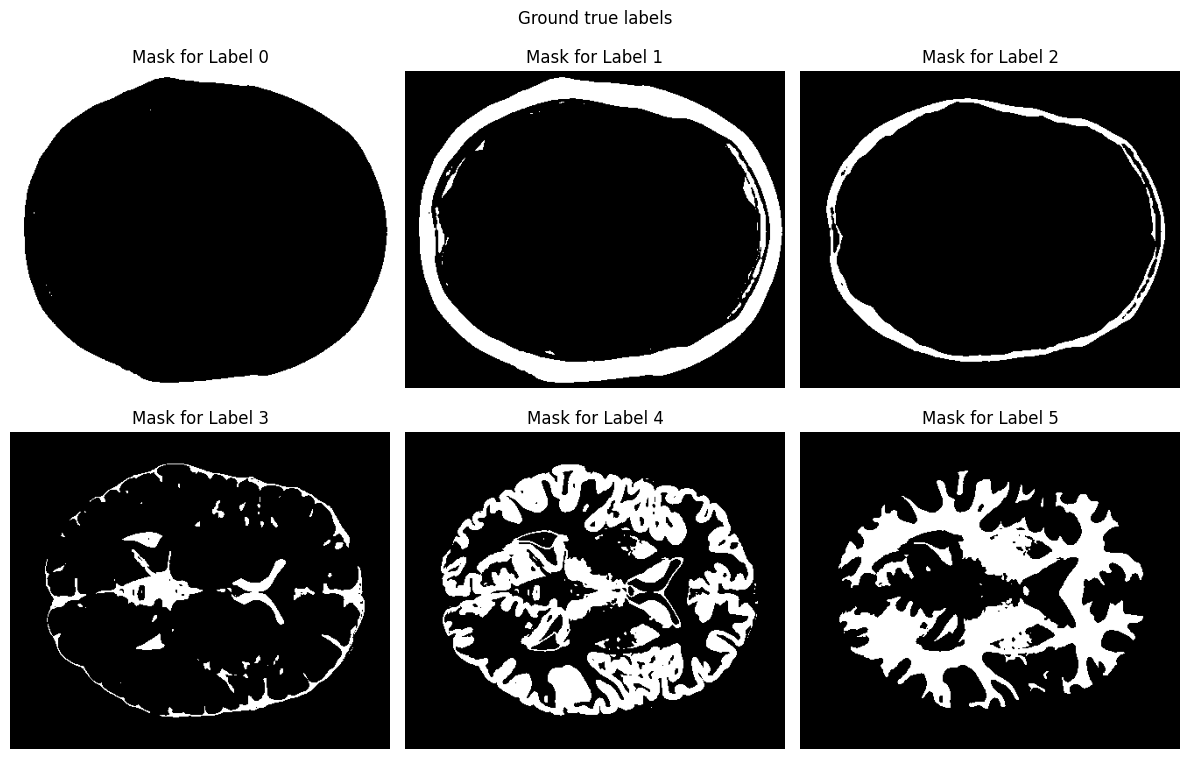

In [444]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reference_labels == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.suptitle("Ground true labels")
plt.tight_layout()
plt.show()


# Segmentation Algorithm

In [445]:
# Relevant Libraries
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
import scipy.ndimage as ndimage
from skimage.morphology import convex_hull_image
from sklearn.cluster import KMeans
import numpy as np
from skimage.morphology import disk

0.29492188


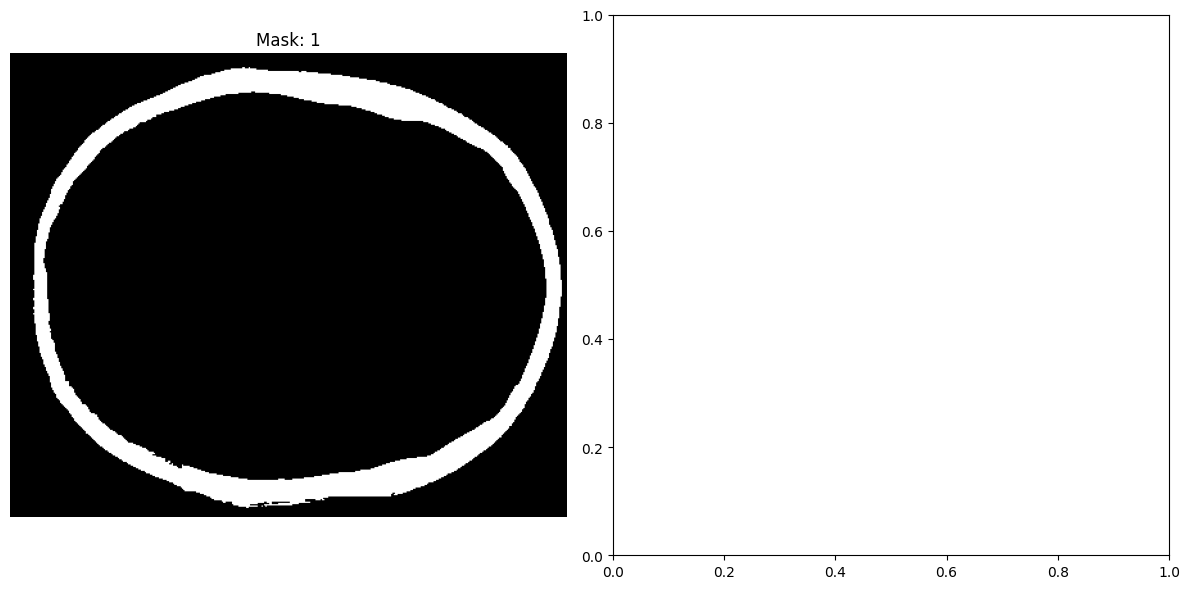

In [446]:
# Normalize mri_stacked image
mri_stacked = (mri_stacked - mri_stacked.min()) / (mri_stacked.max() - mri_stacked.min())

# NOTE: Now our reference img is the whole mri_stacked
reference_img = mri_stacked
reference_labels = mri_labels

temporal_masks = {}

# # Calculate the mean of the reference image over axix 2
# mean_img = np.mean(reference_img, axis=2)

# # Plot the mean image
# plt.imshow(mean_img, cmap='gray')
# plt.show()

# Apply an outsu algorithm to the reference image
threshold = threshold_otsu(reference_img)
binary = reference_img > threshold - 0.02
print(threshold)

# Remove the smaller artificts (holes and objects)
cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(cleaned, min_size=1000)

# Apply two-pass algorithm to the cleaned image to have preliminary labels
labels, num_labels = ndimage.label(cleaned)

# NOTE: I got 3 labels, but I save only the first label
# Save the temporal mask label 1
temporal_masks["1"] = (labels == 1).astype(int)
# temporal_masks["tmp_internal_region"] = (labels == 2).astype(int)

# Plot temporal masks
utils.plot_masks(temporal_masks, slice_id = 0)

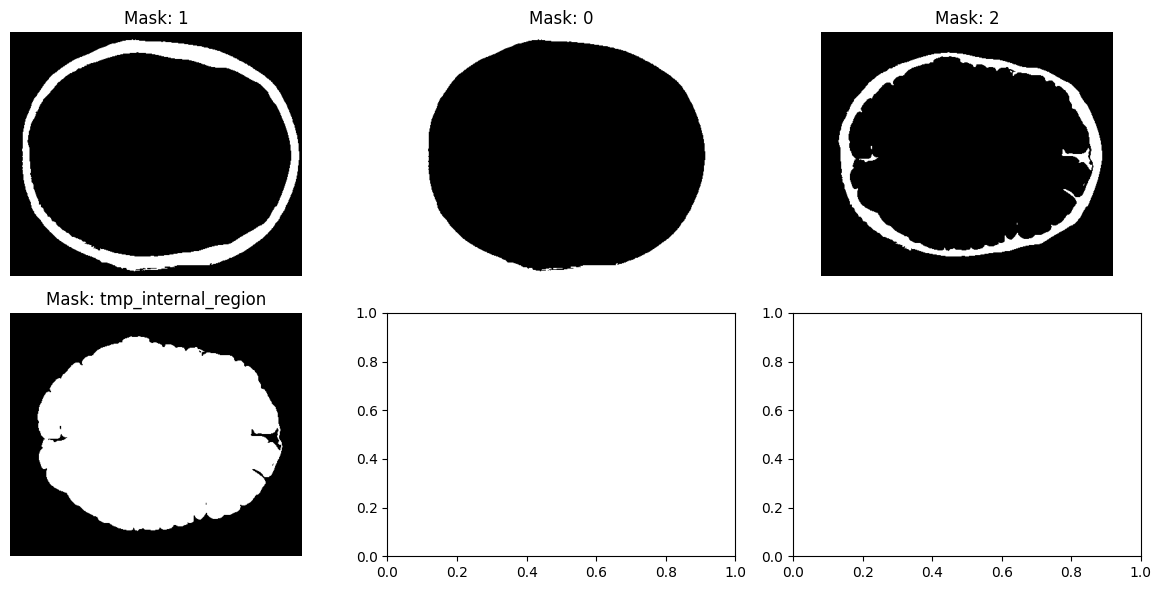

In [447]:
# Invert the cleaned image
inverted = ~cleaned

# Got the others labels from the inverted image
# using the same two-pass algorithm
inverted_labels, num_labels = ndimage.label(inverted)

# Only consider the two first labels and all the other to zero
inverted_labels[inverted_labels > 2] = 0

# Save temporal masks label 0 and 2
temporal_masks["0"] = (inverted_labels == 1).astype(int)
temporal_masks["2"] = (inverted_labels == 2).astype(int)

# Got the tmp internal region by considering all that is
# not part of the mask 0, 1, 2
tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

# Plot temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=3, slice_id=0)

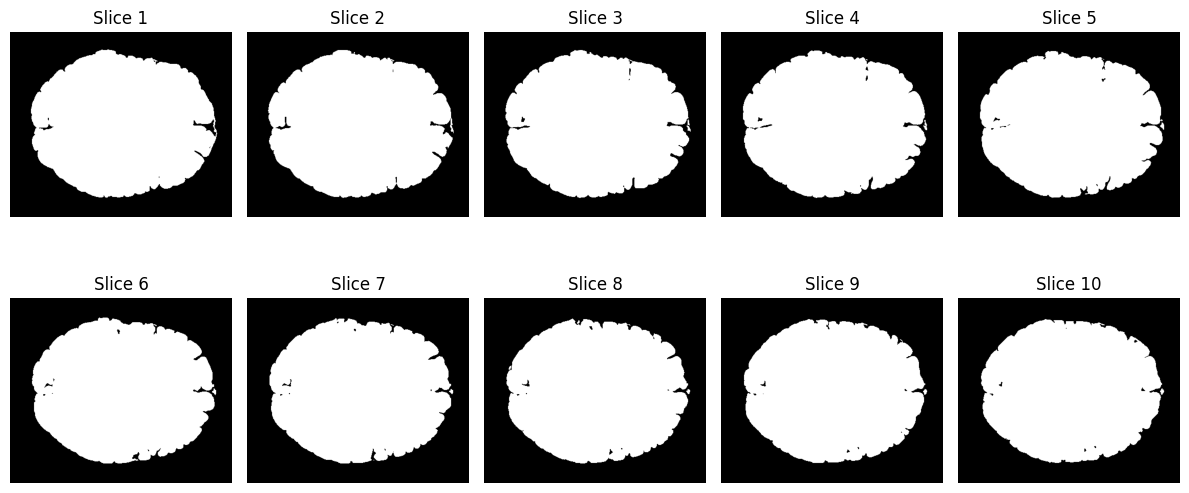

In [448]:
temporal_masks["tmp_internal_region"].shape

# Plot every tmp_internal_region slice
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(temporal_masks["tmp_internal_region"][:,:,i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

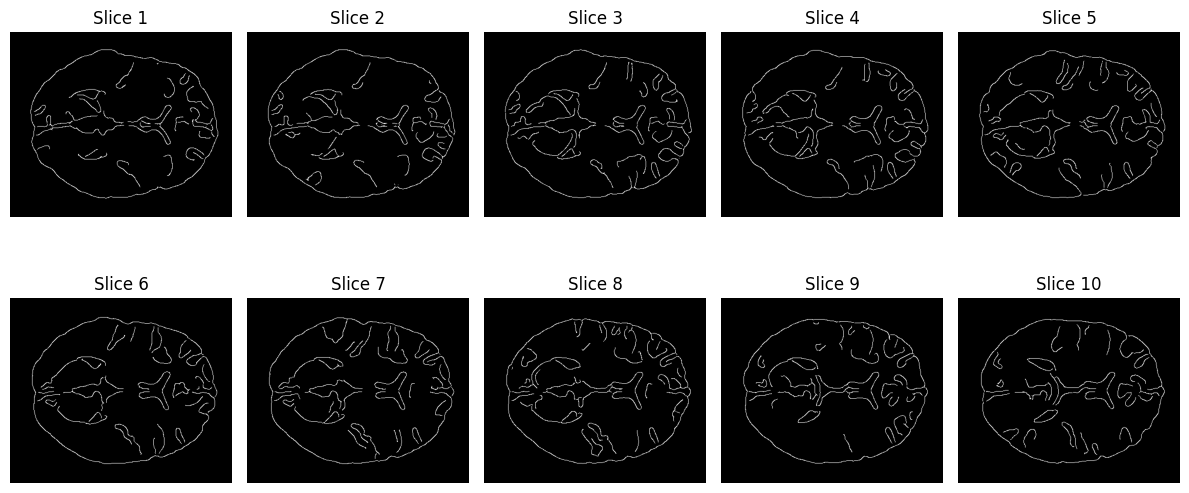

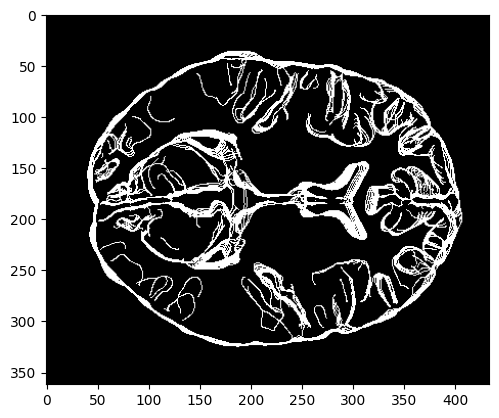

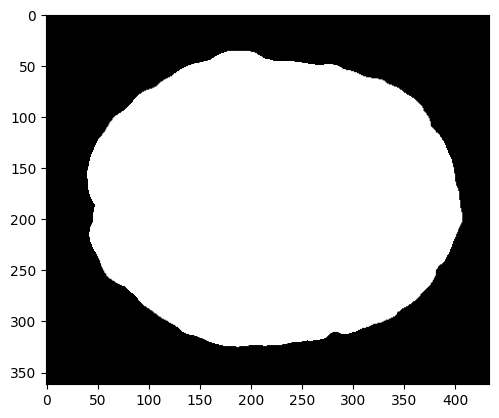

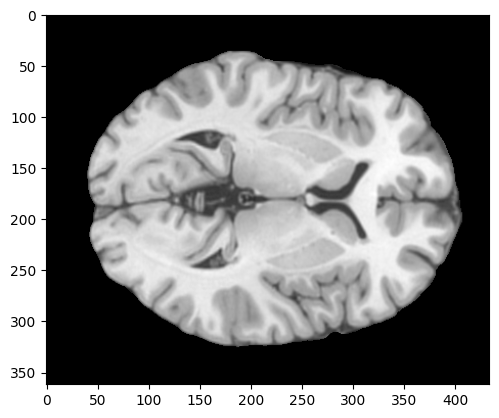

In [449]:
from skimage.feature import canny
# NOTE: convex hull is expensive use edge detection

# Dilation of the tmp_internal_region
selem = disk(3)

# Apply canny edge detection to the tmp_internal_region to each slice
edges = np.zeros_like(temporal_masks["tmp_internal_region"])
for i in range(temporal_masks["tmp_internal_region"].shape[2]):

    dilated = ndimage.binary_dilation(temporal_masks["tmp_internal_region"][:,:,i], selem)

    # Apply the tmp_internal_region to the reference image
    internal_region = reference_img[:,:,i] * dilated

    edges[:,:,i] = canny(internal_region, sigma=3)

# Plot the edges
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(edges[:,:,i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Aggregation of the edges
aggregated_edges = np.sum(edges, axis=2) > 0

# Plot the aggregated edges
plt.imshow(aggregated_edges, cmap='gray')
plt.show()

# Fill the holes of the aggregated edges
filled_aggregated_edges = ndimage.binary_fill_holes(aggregated_edges)

# Plot the filled edges
plt.imshow(filled_aggregated_edges, cmap='gray')
plt.show()

# Extend one dimension and repeat the mask to all the slices
filled_aggregated_edges = filled_aggregated_edges[:, :, np.newaxis]

# The cumulativative mask is broadcasted to all the slices
# by the new axis added before
masked_internal_region = mri_stacked * filled_aggregated_edges

plt.imshow(masked_internal_region[:,:,0], cmap='gray')
plt.show()



In [450]:
# # NOTE: convex hull is expensive to compute
# # Alternative solution: leverage the information of each channel to create a 
# # mask that is the union of all the masks

# # Create a mask that is the union of all the masks
# cumultaive_mask = temporal_masks["tmp_internal_region"].sum(axis=2) > 0
# # NOTE: explain why it doesn't matter to a unique tmp_internal_region for all the channels
# print(cumultaive_mask.shape)

# # Plot the final mask
# plt.imshow(cumultaive_mask, cmap='gray')
# plt.show()

# # # Apply closing to the cumultaive mask
# # cumultaive_mask = binary_closing(cumultaive_mask, disk(3))

# # Fill holes to the cumultaive mask
# cumultaive_mask = ndimage.binary_fill_holes(cumultaive_mask)

# # Dilate a little bit the cumultaive mask
# cumultaive_mask = ndimage.binary_dilation(cumultaive_mask, disk(2))

# plt.imshow(cumultaive_mask, cmap='gray')
# plt.show()

# # Extend one dimension and repeat the mask to all the slices
# cumultaive_mask = cumultaive_mask[:, :, np.newaxis]

# # The cumulativative mask is broadcasted to all the slices
# # by the new axis added before
# masked_internal_region = mri_stacked * cumultaive_mask

# plt.imshow(masked_internal_region[:,:,0], cmap='gray')
# plt.show()

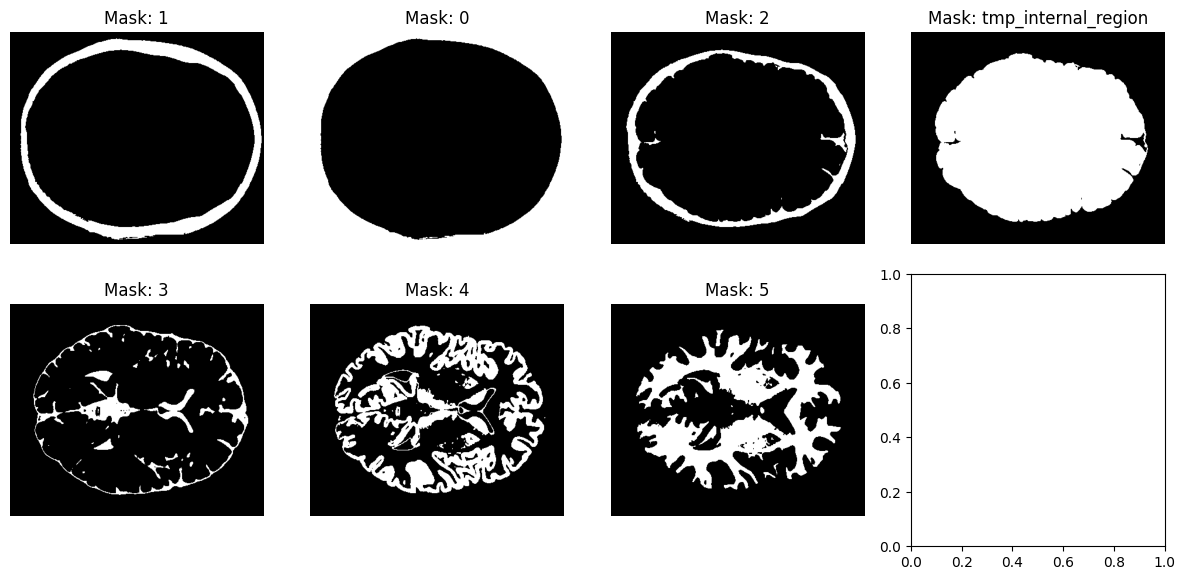

In [451]:
# Apply k-means clustering to the partial_reference image
# NOTE: one alternative is apply otsu or constant thresholds

internal_labels, order = utils.kmeans_segmentation(masked_internal_region, n_clusters=4)

# Use the order to fit the mask 3, 4, 5
# NOTE: I don't use order 0 because it corresponds to the external region
temporal_masks["3"] = (internal_labels == order[1]).astype(int)
temporal_masks["4"] = (internal_labels == order[2]).astype(int)
temporal_masks["5"] = (internal_labels == order[3]).astype(int)

# Plot the temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4, slice_id=0)

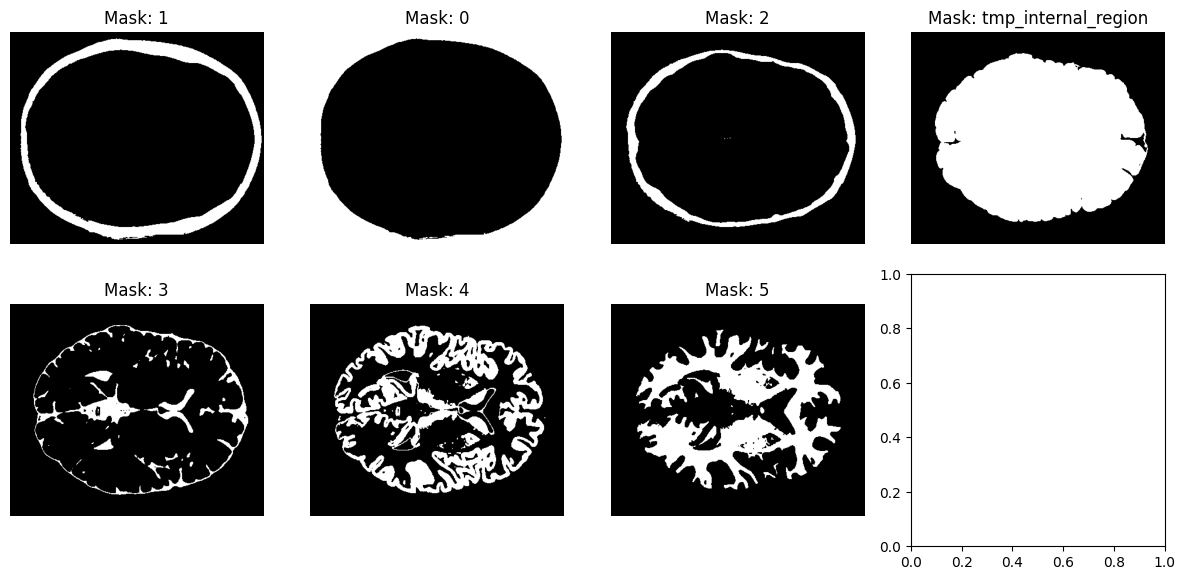

In [452]:
# NOTE: There are certain difference between the convex hull 
# and the internal region, which consequently affect the
# k-means clustering, and mask 2. Then, I need to refine
# the mask 2

# Refine the mask 2 by considering all the others masks
tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
            temporal_masks["3"] + temporal_masks["4"] +
            temporal_masks["5"] )
temporal_masks["2"] = (tmp_mask == 0).astype(int)

# Plot the temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4, slice_id=0)

0.236328125


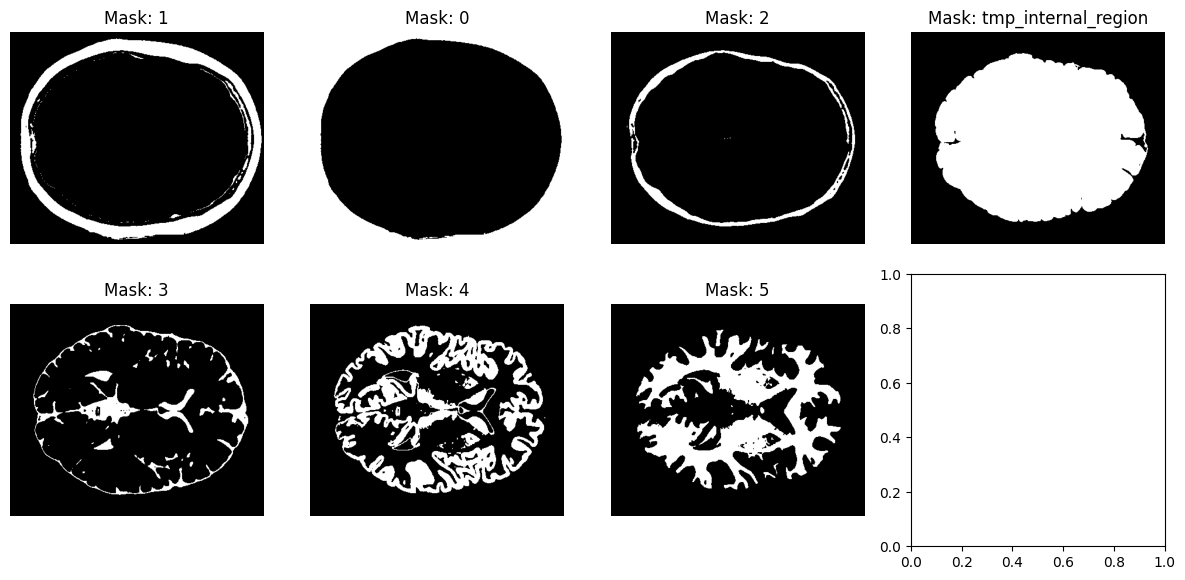

In [453]:
# NOTE: In the ground trues, the mask 1 and 2 have some
# parts in between each other. Then, I need to refine 
# these two masks

# Add the mask 1 and 2 in a tmp_mask
tmp_mask = temporal_masks["1"] + temporal_masks["2"]

# Apply tmp_mask to the reference image
tmp_masked = reference_img * tmp_mask

# # Add together the mask 1 and 2 in a segmented image
# segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, labels = [1, 2, 3])

# # Plot histograms frequencies of the mask 1 and 2
# utils.plot_frequencies(reference_img, segmented_img, labels2plot = [1, 2, 3])

# Apply outsu algorithm to the masked image
# NOTE: I add some constant value to the threshold
# to improve the segmentation
threshold = threshold_otsu(tmp_masked)
binary = tmp_masked > threshold - 0.07
print(threshold)

# plt.imshow(binary[:,:,0], cmap='gray')
# plt.show()

# Add the refined mask 1 and 2 to the temporal masks
temporal_masks["1"] = binary.astype(int)
temporal_masks["2"] = tmp_mask - binary

utils.plot_masks(temporal_masks, 2, 4, slice_id=0)

Text(0.5, 1.0, 'Final Segmented Image')

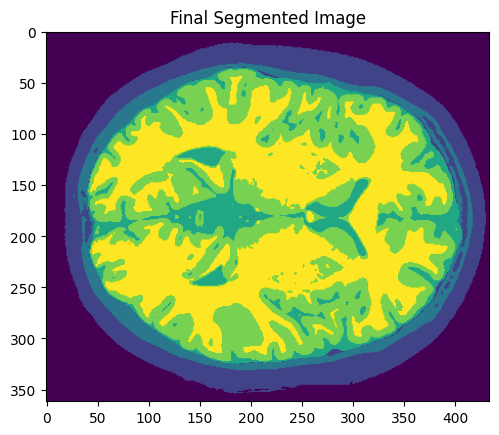

In [454]:
segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=0)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.title('Final Segmented Image')

In [455]:
# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,0], segmented_img)

print(metrics)
metrics_by_label

# NOTE: I decided to keep these metrics for the following reasons
# 1. jaccard and dice are very similar, so I keep only one of them and can capture the spatial info
# 2. auprc although doesn't aware of the true negatives, it can capture the precision-recall trade-off
# - also auprc althoguht doesn't capture the spatial info, it can capture the precision-recall trade-off
# - also I choose to don't use auc because it can be misleading in the case of imbalanced data
# 3. accuracy is a good metric to capture the overall performance as well as micro_f1
# I choose the micro variants over weighted and macro because I want to capture the overall performance
# micro handle in some way the imbalanced data  and it's a good metric to capture the overall performance
# although weighted can help to capture the performance of the minority class, I choose to don't use it
# because it can be an overoptimistic metric in the case of imbalanced data (because it scales the values too much)

# Why precision and recall by separate??? Because it depends on the application

{'micro_jaccard': 0.9082, 'micro_dice': 0.9519, 'auprc': 0.9453, 'micro_f1': 0.9519, 'accuracy': 0.9519}


{'jaccard label 0': 0.9513,
 'f1 label 0': 0.975,
 'auprc label 0': 0.9757,
 'jaccard label 1': 0.8634,
 'f1 label 1': 0.9267,
 'auprc label 1': 0.9379,
 'jaccard label 2': 0.9301,
 'f1 label 2': 0.9638,
 'auprc label 2': 0.9647,
 'jaccard label 3': 0.7448,
 'f1 label 3': 0.8537,
 'auprc label 3': 0.8607,
 'jaccard label 4': 0.8933,
 'f1 label 4': 0.9436,
 'auprc label 4': 0.9572,
 'jaccard label 5': 0.951,
 'f1 label 5': 0.9749,
 'auprc label 5': 0.9755}

In [456]:
for slice_idx in range(6):
    segmented_labels = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id = slice_idx)
    reference_labels = mri_labels[:,:,slice_idx]

    metrics,  metrics_by_label = utils.calculate_metrics(reference_labels, segmented_labels, f"Slice {slice_idx}")

    print(metrics)
    print(metrics_by_label)

Metrics for Slice 0 

{'micro_jaccard': 0.9082, 'micro_dice': 0.9519, 'auprc': 0.9453, 'micro_f1': 0.9519, 'accuracy': 0.9519}
{'jaccard label 0': 0.9513, 'f1 label 0': 0.975, 'auprc label 0': 0.9757, 'jaccard label 1': 0.8634, 'f1 label 1': 0.9267, 'auprc label 1': 0.9379, 'jaccard label 2': 0.9301, 'f1 label 2': 0.9638, 'auprc label 2': 0.9647, 'jaccard label 3': 0.7448, 'f1 label 3': 0.8537, 'auprc label 3': 0.8607, 'jaccard label 4': 0.8933, 'f1 label 4': 0.9436, 'auprc label 4': 0.9572, 'jaccard label 5': 0.951, 'f1 label 5': 0.9749, 'auprc label 5': 0.9755}
Metrics for Slice 1 

{'micro_jaccard': 0.9086, 'micro_dice': 0.9521, 'auprc': 0.9472, 'micro_f1': 0.9521, 'accuracy': 0.9521}
{'jaccard label 0': 0.9503, 'f1 label 0': 0.9745, 'auprc label 0': 0.9751, 'jaccard label 1': 0.8633, 'f1 label 1': 0.9267, 'auprc label 1': 0.9386, 'jaccard label 2': 0.9261, 'f1 label 2': 0.9616, 'auprc label 2': 0.9627, 'jaccard label 3': 0.7641, 'f1 label 3': 0.8663, 'auprc label 3': 0.8732, 'jacca

In [457]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(reference_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 42726 pixels
Label 1: 23545 pixels
Label 2: 9357 pixels
Label 3: 10811 pixels
Label 4: 39226 pixels
Label 5: 31443 pixels


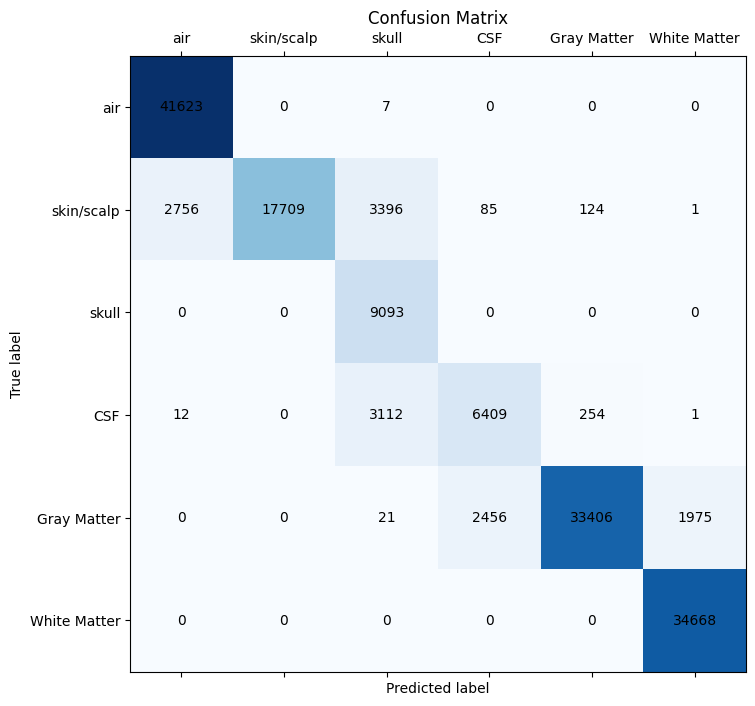

In [ ]:
utils.plot_confusion_matrix(reference_labels, segmented_img)